In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator

import models


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

# Compare reversible MA vs MM model

Yokota

| name                              | rxn                                              |
| :---                              | :---                                             |
| rubisco o2                        | 0 -> 2-phosphoglycolate                          |
| phosphoglycolate phosphatase      | 2-phosphoglycolate -> Glycolate                  |
| glycolate oxidase                 | Glycolate -> Glyoxylate                          |
| glycine transaminase              | Glyoxylate -> Glycine                            |
| glycine decarboxylase             | 2 Glycine -> Serine                              |
| serine glyoxylate transaminase    | Glyoxylate + Serine -> Glycine + Hydroxypyruvate |
| glycerate dehydrogenase           | Hydroxypyruvate -> Glycerate                     |
| glycerate kinase                  | Glycerate -> 0 (3PG)                             |

| Enzyme                           | Keq    |
| -------------------------------- | ------ |
| phosphoglycolate phosphatase     | 3.1e5  |
| glycolate oxidase                | 3e15   |
| glycine transaminase             | 3e1    |
| glycine decarboxylase            | 3.6e-3 |
| glycine hydroxymethyltransferase | 0.07   |
| serine glyoxylate transaminase   | 6      |
| glycerate dehydrogenase          | 8.7e4  |
| glycerate kinase                 | 4.9e2  |

| Enzyme                           | Reaction                                                                                             | Keq    | Source       |
| :-------------------------------- | :------------------------------------------------------------                                         | ------ | ------------ |
| phosphoglycolate phosphatase     | H2O + 2-Phosphoglycolate <=> Orthophosphate + Glycolate                                              | 3.1e5  | Equilibrator |
| glycolate oxidase                | Oxygen + Glycolate <=> Hydrogen peroxide + Glyoxylate                                                | 3e15   | Equilibrator |
| glycine transaminase             | L-Glutamate + Glyoxylate <=> 2-Oxoglutarate + Glycine                                                | 3e1    | Equilibrator |
| glycine decarboxylase            | NAD  + Glycine + Tetrahydrofolate + H2O <=> NADH + NH3 + 5,10-Methylenetetrahydrofolate + CO2(total) | 3.6e-3 | Equilibrator |
| glycine hydroxymethyltransferase | H2O + Glycine + 5,10-Methylenetetrahydrofolate <=> L-Serine + Tetrahydrofolate                       | 0.07   | Equilibrator |
| serine glyoxylate transaminase   | Glyoxylate + L-Serine <=> Glycine + Hydroxypyruvate                                                  | 6      | Equilibrator |
| glycerate dehydrogenase          | NADH + Hydroxypyruvate <=> NAD  + D-Glycerate                                                        | 8.7e4  | Equilibrator |
| glycerate kinase                 | ATP + D-Glycerate <=> ADP + 3-Phospho-D-glycerate                                                    | 4.9e2  | Equilibrator |
| catalase                         | 2 Hydrogen peroxide <=> 2 H2O + Oxygen                                                               | 4.3e33 | Equilibrator |
|                                  | Glyoxylate + H2O2 <=> Formate + CO2(total)                                                           | 7.1e65 | Equilibrator |
|                                  | Hydroxypyruvate + H2O2 <=> Glycolate + CO2(total)                                                    | 3.3e72 | Equilibrator |

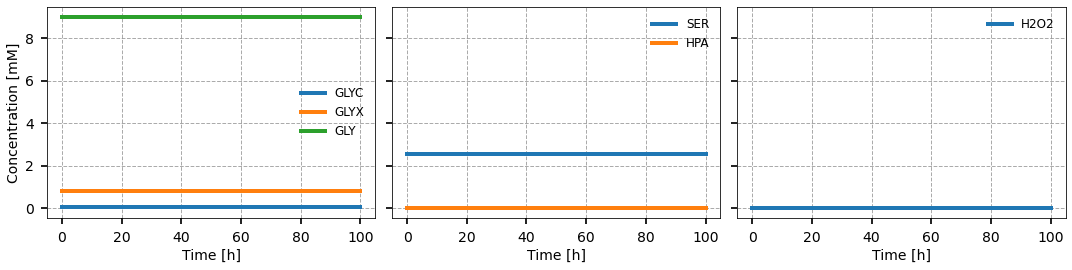

In [24]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

m = models.get_yokota()
s = Simulator(m)
s.initialise(y0_yokota)
t, y = s.simulate(100)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX", "GLY"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
)
fig.tight_layout()
plt.show()

In [25]:
from models.shared_rate_functions import (
    reversible_michaelis_menten_1s_1p,
    reversible_michaelis_menten_2s_2p,
)

In [26]:
m.add_parameters(
    {
        "keq_glycine_decarboxylase": 3.6e-3,
        "keq_glycine_transaminase": 3e1,
        "keq_serine_glyoxylate_transaminase": 6,
        # Influx and outflux
        # "keq_glycerate_dehydrogenase": 8.7e4,
        # "keq_phosphoglycolate_phosphatase": 3.1e5,
    }
)


m.update_reaction(
    rate_name="glycine_decarboxylase",
    function=reversible_michaelis_menten_1s_1p,
    parameters=[
        "vmax_glycine_decarboxylase",
        "km_glycine_decarboxylase",
        "keq_glycine_decarboxylase",
    ],
    reversible=True,
)
m.update_reaction(
    rate_name="glycine_transaminase",
    function=reversible_michaelis_menten_1s_1p,
    parameters=[
        "vmax_glycine_transaminase",
        "km_glycine_transaminase",
        "keq_glycine_transaminase",
    ],
    reversible=True,
)
m.update_reaction(
    rate_name="serine_glyoxylate_transaminase",
    function=reversible_michaelis_menten_2s_2p,
    parameters=[
        "vmax_ser_gly_transaminase",
        # "km_transaminase_glyxoylate",
        "km_transaminase_serine",  # the larger one
        "keq_serine_glyoxylate_transaminase",
    ],
    reversible=True,
)

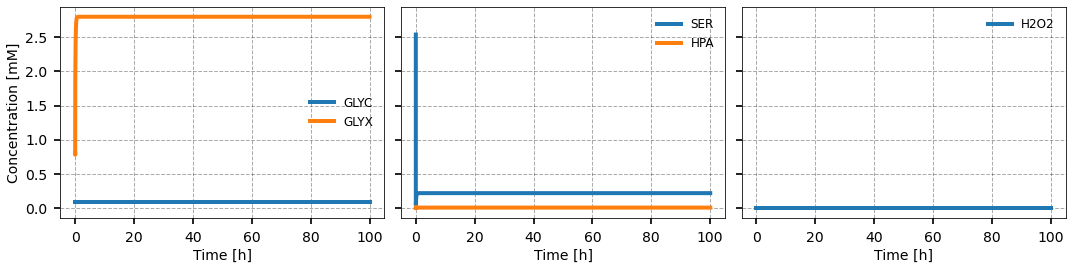

In [28]:
y0_yokota = {
    "GLYC": 0.08999999999999997,
    "GLYX": 0.7964601794673895,
    "GLY": 8.999999975082668,
    "SER": 2.538560856085531,
    "HPA": 0.009782608672218024,
    "H2O2": 0.010880542843616853,
}

s = Simulator(m)
s.initialise(y0_yokota)
t, y = s.simulate(100)
fig, ax = s.plot_grid(
    [
        ["GLYC", "GLYX"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
    xlabels="Time [h]",
    ylabels="Concentration [mM]",
)
fig.tight_layout()
plt.show()

In [30]:
y0 = {
    "GLY": 65.07271201055974,
    "GLYC": 0.09000000000000001,
    "GLYX": 2.7984610297226356,
    "H2O2": 0.010880542843616852,
    "HPA": 0.009782608695651916,
    "SER": 0.22130176323801537,
}

In [31]:
c, v = s.parameter_scan_with_fluxes("v_influx", np.linspace(0, 200))

v_influx:   0%|          | 0/50 [00:00<?, ?it/s]

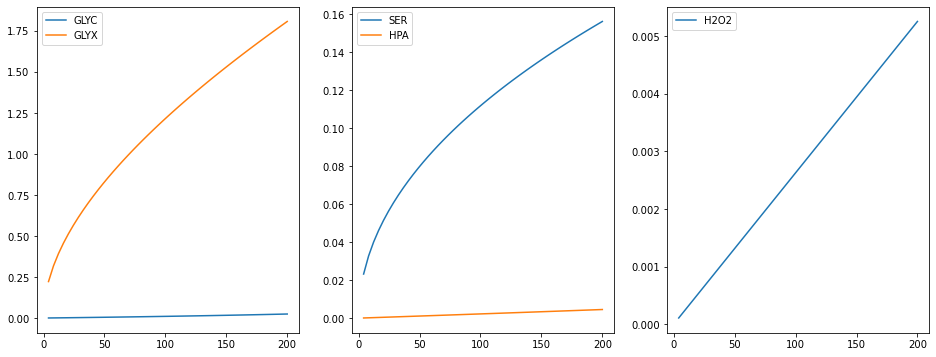

In [41]:
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(16, 6))
for ax, group in zip(
    axs.flatten(),
    [
        ["GLYC", "GLYX"],
        ["SER", "HPA"],
        ["H2O2"],
    ],
):
    ax.plot(c.loc[:, group])
    ax.legend(group)